In [91]:
import copy
import math
import time
import struct

import numpy as np                  # 矩阵
import matplotlib.pyplot as plt     # 绘图

from numba import njit              # 加速 cpu
from numba import cuda              # 加速 gpu(cuda)
from pathlib import Path            # 处理路径

from Activation import Activation
from ProgressBar import ProgressBar 

def tanh(x):
    return np.tanh(x)

def softmax(x):
    exp = np.exp(x - x.max())
    return exp / exp.sum()

def d_tanh(data):
    # d_tanh([1, 2, 3, 4])
    # return np.diag(1 / (np.cosh(data) ** 2))
    return 1 / (np.cosh(data) ** 2)

def d_softmax(data):
    sm = softmax(data)
    # 单元对角矩阵 - 行列向量扩充
    # d_softmax(np.array([1, 2, 3, 4]))
    return np.diag(sm) - np.outer(sm, sm)

# 验证 d_softmax
# h = 0.000001 # 逐渐增大或者减小验证收敛性
# input_len = 4
# for i in range(input_len):
#     test_input = np.random.rand(input_len)
#     dervative = d_softmax(test_input)
#     value_1 = softmax(test_input)
#     test_input[i] += h
#     value_2 = softmax(test_input)
#     # print((value_2 - value_1) / h) # 求导公式
#     # print(dervative[i]) # 推出来的公式
#     print(dervative[i] - ((value_2 - value_1) / h))

# # 验证 d_tanh
# h = 0.00001
# input_len = 4
# for i in range(input_len):
#     test_input = np.random.rand(input_len)
#     dervative = d_tanh(test_input)
#     value_1 = tanh(test_input)
#     test_input[i] += h
#     value_2 = tanh(test_input)
#     # print((value_2 - value_1) / h) # 求导公式
#     # print(dervative[i]) # 推出来的公式
#     print(dervative[i] - ((value_2 - value_1) / h))

def init_paramters_b(layer): # layer 输入层数
    dist = distribution[layer]['b']
    # 数组的大小是dimensions[layer] = [28 * 28, 10]
    # 等价于 randdouble(0, 1) * (r - l) + l
    res = np.random.rand(dimensions[layer]) * (dist[1] - dist[0]) + dist[0]
    # print("深度:" + str(layer) + "初始化 b: " + str(res))
    return res

def init_paramters_w(layer):
    dist = distribution[layer]['w']
    # print("深度:" + str(layer) + "初始化 w 数组大小" + str(dimensions[layer - 1]) + " * " + str(dimensions[layer]))
    # 返回二维的随机数组
    return np.random.rand(dimensions[layer - 1], dimensions[layer]) * (dist[1] - dist[0]) + dist[0]

def init_paraments():
    parameter = []
    for i in range(len(distribution)):
        layer_parameter = {}
        for j in distribution[i].keys():
            if (j == 'b'):
                layer_parameter['b'] = init_paramters_b(i)
            elif (j == 'w'):
                layer_parameter['w'] = init_paramters_w(i)
        parameter.append(layer_parameter)
    return parameter

# 计算矩阵
def predict(img, parameters):
    l_0_in = img + parameters[0]['b']
    l_0_out = activation[0](l_0_in)
    l_1_in = np.dot(l_0_out, parameters[1]['w']) + parameters[1]['b']
    l_1_out = activation[1](l_1_in)
    return l_1_out

# 损失函数
def sqr_loss(img, lab, parameters):
    y_pred = predict(img, parameters)
    y = one_hot[lab];
    diff = y - y_pred
    return np.dot(diff, diff) # 公式相等

# 求梯度
def grad_parameters(img, lab, parameters):
    l_0_in = img + parameters[0]['b']
    l_0_out = activation[0](l_0_in)
    l_1_in = np.dot(l_0_out, parameters[1]['w']) + parameters[1]['b']
    l_1_out = activation[1](l_1_in)

    diff = one_hot[lab] - l_1_out;
    act_1 = np.dot(d_softmax(l_1_in), diff)
    
    # 把 tanh 的对角矩阵拆分优化
    grad_b_0 = -2 * d_tanh(l_0_in) * np.dot(parameters[1]['w'], act_1)
    grad_b_1 = -2 * act_1
    grad_w_1 = -2 * np.outer(l_0_out, act_1)
    # print(l_0_out)
    return {'b0': grad_b_0, 'b1': grad_b_1, 'w1': grad_w_1}

def show_train(index):
    print("lab:", end = ' '), print(train_lab[index])
    plt.imshow(train_img[index].reshape(28, 28), cmap = 'gray')
    plt.show()

def show_valid(index):
    print("lab:", end=' '), print(valid_lab[index])
    plt.imshow(valid_img[index].reshape(28, 28), cmap='gray')
    plt.show()

def show_test(index):
    print("lab:", end = ' '), print(test_lab[index])
    plt.imshow(test_img[index].reshape(28, 28), cmap = 'gray')
    plt.show()


# 验证测试集
def valid_loss(parameters):
    loss_accu = 0 # 偏差值的累加
    for img_i in range(valid_num): # 测试集的数量 10000
        loss_accu += sqr_loss(valid_img[img_i], valid_lab[img_i], parameters)
    return loss_accu / (valid_num / 10000)

# valid 集合的验证 求 valid 集合的准确率
def valid_accuracy(parameters):
    correct = [predict(valid_img[img_i], parameters).argmax() == valid_lab[img_i] for img_i in range(valid_num)]
    # print("validation accuracy: {}".format(correct.count(True) / len(correct)))
    return correct.count(True) / len(correct)

def train_loss(parameters):
    loss_accu=0
    for img_i in range(train_num):
        loss_accu += sqr_loss(train_img[img_i],train_lab[img_i],parameters)
    return loss_accu / (train_num / 10000)

def train_accuracy(parameters):
    correct = [predict(train_img[img_i],parameters).argmax()==train_lab[img_i] for img_i in range(train_num)]
    return correct.count(True) / len(correct)

def test_accuracy(parameters):
    correct = [predict(test_img[img_i], parameters).argmax() == test_lab[img_i] for img_i in range(test_num)]
    # print("validation accuracy: {}".format(correct.count(True) / len(correct)))
    return correct.count(True) / len(correct)

# 分组训练减少时间
def train_batch(current_batch, parameters):
    # 集合梯度初始化
    grad_accu = grad_parameters(train_img[current_batch * batch_size + 0], train_lab[current_batch * batch_size + 0], parameters)
    for img_i in range(1, batch_size):
        grad_tmp = grad_parameters(train_img[current_batch*batch_size + img_i], train_lab[current_batch * batch_size + img_i], parameters)
        for key in grad_accu.keys():
            grad_accu[key] += grad_tmp[key] # += b0 b1 w1 ......
    for key in grad_accu.keys(): # 做平均
        grad_accu[key] /= batch_size
    return grad_accu

# 梯度下降
def combine_parameters(parameters, grad, learn_rate):
    parameter_tmp = copy.deepcopy(parameters)
    parameter_tmp[0]['b'] -= learn_rate * grad['b0']
    parameter_tmp[1]['b'] -= learn_rate * grad['b1']
    parameter_tmp[1]['w'] -= learn_rate * grad['w1']
    return parameter_tmp


In [92]:
dimensions = [28 * 28, 10] # 存储两个数据 输入数量 m 和 输出数量 n
activation = [tanh, softmax]

distribution = [ # 列表套字典
    {'b' : [0, 0]}, # 第一层的偏置函数和第二层的偏置函数推荐设置为 0
    {'b' : [0, 0], 'w': [-math.sqrt(6 / (dimensions[0] + dimensions[1])), math.sqrt(6 / (dimensions[0] + dimensions[1]))]}, # 假设只有两层 784 -> 10
]
# 初始化
parameters = init_paraments()
differential = {softmax:d_softmax,tanh:d_tanh}
# 测试正确性
# print(predict(np.random.rand(784), parameters))

# 读入测试集
dataset_path = Path('./MNIST')
train_img_path = dataset_path / 'train-images.idx3-ubyte'
train_lab_path = dataset_path / 'train-labels.idx1-ubyte'
test_img_path = dataset_path / 't10k-images.idx3-ubyte'
test_lab_path = dataset_path / 't10k-labels.idx1-ubyte'

train_num = 50000 # 同时给问题和答案 # 过拟合
valid_num = 10000 # 给问题不给答案 # 永远不能看见 # 测验 # 自己可以调整
test_num = 10000 # 只能看到结果的数据

with open(train_img_path, "rb") as f:
    struct.unpack('>4i', f.read(16))
    # train_img = np.fromfile(f, dtype = np.uint8).reshape(-1, 28 * 28)
    tmp_img = np.fromfile(f, dtype = np.uint8).reshape(-1, 28 * 28) / 255 # 防止二值化 / 255 -> 灰度最大值
    train_img = tmp_img[:train_num]
    valid_img = tmp_img[train_num:]

with open(test_img_path, "rb") as f:
    struct.unpack('>4i', f.read(16))
    test_img = np.fromfile(f, dtype = np.uint8).reshape(-1, 28 * 28) / 255

with open(train_lab_path, "rb") as f:
    struct.unpack('>2i', f.read(8))
    # train_lab = np.fromfile(f, dtype = np.uint8)
    tmp_lab = np.fromfile(f, dtype = np.uint8)
    train_lab = tmp_lab[:train_num]
    valid_lab = tmp_lab[train_num:]

with open(test_lab_path, "rb") as f:
    struct.unpack('>2i', f.read(8))
    test_lab = np.fromfile(f, dtype = np.uint8)
print(test_img.shape)

(10000, 784)


In [93]:
# show_train(np.random.randint(train_num))
# show_valid(np.random.randint(valid_num))
# show_test(np.random.randint(test_num))

one_hot = np.identity(dimensions[-1]) # 10 * 10 的单位矩阵(对角线都是 1) # python 中 -1 会回环

# print(sqr_loss(train_img[0], train_lab[0], parameters))
# print(grad_parameters(train_img[2],train_lab[2],parameters))

# # 验证 b1
# h = 0.00001
# for i in range(10):
#     img_i = np.random.randint(50000)
#     test_parameters = init_paraments()
#     derivative = grad_parameters(train_img[img_i], train_lab[img_i], test_parameters)['b1']
#     value1 = sqr_loss(train_img[img_i], train_lab[img_i], test_parameters)
#     test_parameters[1]['b'][i] += h
#     value2 = sqr_loss(train_img[img_i], train_lab[img_i], test_parameters)
#     print(derivative[i] - ((value2 - value1) / h))

# 验证 w1
# grad_list = []
# h = 0.00001
# for i in range(784):
#     for j in range(10):
#         img_i=np.random.randint(train_num)
#         test_parameters = parameters
#         derivative=grad_parameters(train_img[img_i],train_lab[img_i],test_parameters)['w1']
#         value1=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
#         test_parameters[1]['w'][i][j] += h
#         value2=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
#         grad_list.append(derivative[i][j] - (value2 - value1) / h)
# print(np.abs(grad_list).max())

# # 验证b0
# grad_list = []
# h = 0.01
# for i in range(784):
#     img_i=np.random.randint(train_num)
#     test_parameters = parameters
#     derivative=grad_parameters(train_img[img_i],train_lab[img_i],test_parameters)['b0']
#     value1=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
#     test_parameters[0]['b'][i] += h
#     value2=sqr_loss(train_img[img_i],train_lab[img_i],test_parameters)
#     grad_list.append(derivative[i] - (value2 - value1) / h)
# print(np.abs(grad_list).max())
# print(valid_loss(parameters))
# print(valid_accuracy(parameters))

batch_size = 100 # 100 组
current_epoch = 0
train_loss_list = []
valid_loss_list = []
train_accu_list = []
valid_accu_list = []

In [103]:

print("训练集的正确率: {:.5f}".format(test_accuracy(parameters))) # 训练之后的正确率
print("测试集的正确率: {:.5f}".format(valid_accuracy(parameters))) # 训练之后的正确率
# 训练
epoch_num = 5 
# 进度条
total_steps = train_num // batch_size * epoch_num
progress_bar = ProgressBar(total_steps)

# 开始训练
for epoch in range(epoch_num):
    for i in range(train_num // batch_size):
        # if (i % 100 == 99):
        #     print("runing batch {} / {}".format(i + 1, train_num // batch_size))
        progress_bar.update(epoch * (train_num // batch_size) + i + 1)
        grad_tmp = train_batch(i, parameters) # 求现在的梯度
        parameters = combine_parameters(parameters, grad_tmp, 0.5) # 如果发现损失函数上下波动说明学习率高了
    current_epoch += 1
    train_loss_list.append(train_loss(parameters))
    train_accu_list.append(train_accuracy(parameters))
    valid_loss_list.append(valid_loss(parameters))
    valid_accu_list.append(valid_accuracy(parameters))
print("")
print("训练集的正确率: {:.5f}".format(test_accuracy(parameters))) # 训练之后的正确率
print("测试集的正确率: {:.5f}".format(valid_accuracy(parameters))) # 训练之后的正确率

训练集的正确率: 0.92520
测试集的正确率: 0.92740
[████████████████████████████████████████████████████████████] 100.0% Complete
训练集的正确率: 0.92890
测试集的正确率: 0.93170


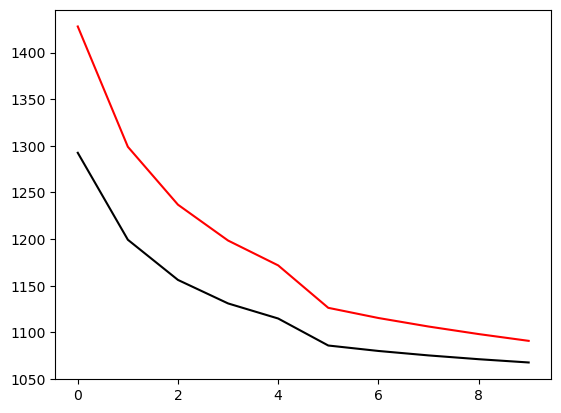

训练集的正确率: 0.92890
测试集的正确率: 0.93170


In [106]:
lower = -30
plt.plot(valid_loss_list[lower:], color = 'black', label = 'validation loss') # 黑色大于红色太多说明出现过拟合
plt.plot(train_loss_list[lower:], color = 'red', label = 'train loss')
plt.show()

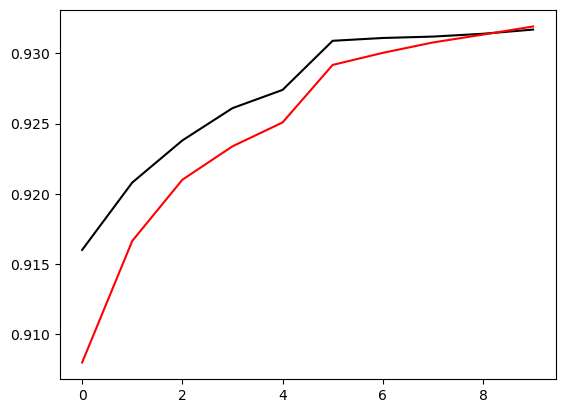

In [105]:
plt.plot(valid_accu_list[lower:], color = 'black', label = 'validation accuracy')
plt.plot(train_accu_list[lower:], color = 'red', label = 'train accuracy')
plt.show()

In [109]:
rand_batch = np.random.randint(train_num // batch_size) # 随机取一个训练集
grad_lr = train_batch(rand_batch, parameters) # 目前的梯度
lr_list = []
lower = -0.5
upper = 0.5
step = 0.1
progress_bar = ProgressBar(int((upper - lower) / step + 1))
for i, lr_pow in enumerate(np.linspace(lower, upper, num = int((upper - lower) / step + 1))):
    progress_bar.update(i)
    learn_rate = 10 ** lr_pow
    parameters_tmp = combine_parameters(parameters, grad_lr, learn_rate)
    train_loss_tmp = train_loss(parameters_tmp)
    lr_list.append([lr_pow, train_loss_tmp])
progress_bar.update(int((upper - lower) / step + 1))


[██████████████████████████████████████████████████████      ] 90.9% Progress

In [110]:
lr_list

[[-0.5, 1090.1709804719926],
 [-0.4, 1089.990664731177],
 [-0.3, 1089.7853473830708],
 [-0.19999999999999996, 1089.561248382143],
 [-0.09999999999999998, 1089.3336347687668],
 [0.0, 1089.1335296849643],
 [0.10000000000000009, 1089.018736035097],
 [0.20000000000000007, 1089.09183215663],
 [0.30000000000000004, 1089.529429163839],
 [0.4, 1090.62963995002],
 [0.5, 1092.889078227306]]

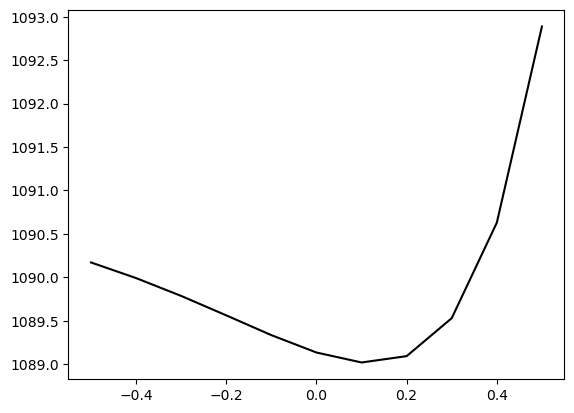

In [111]:
upper=len(lr_list) # 寻找学习率最合适的点(谷底也就是训练损失最低的点)
plt.plot(np.array(lr_list)[:upper, 0], np.array(lr_list)[:upper,1], color='black')
plt.show()

0.9252
